In [1]:
# # Run this and then restart the kernel at the start of each session to install
# # 'teotil3' in development mode
# !pip install -e /home/jovyan/projects/teotil3/

In [2]:
import os

import contextily as cx
import geopandas as gpd
import matplotlib.pyplot as plt
import nivapy3 as nivapy
import numpy as np
import pandas as pd
import seaborn as sn
import teotil3 as teo
from sqlalchemy import text

plt.style.use("ggplot")

# Task 2.15: Testing, documentation and reporting

## Part L: Hotran

In [3]:
# Connect to JupyterHub's PostGIS database
eng = nivapy.da.connect_postgis()

Connection successful.


## 1. Water chemistry

In [4]:
# Read data
xl_path = r"../../data/hotran_data.xlsx"
stn_df = pd.read_excel(xl_path, sheet_name="station")
wc_df = pd.read_excel(xl_path, sheet_name="chem", decimal=",")
wc_df["date"] = pd.to_datetime(wc_df["date"])

print("Water chemsitry data:")
display(wc_df.head())

print("Station details:")
display(stn_df)

Water chemsitry data:


,site_id,type,par,par_name,date,depth1,depth2,filtered,flag,value,unit
0,126-54258,Elv,N-SNOX,Nitrat + nitritt,2013-01-02,NaN,NaN,Ufiltrert,=,1820.0,µg/l N
1,126-54258,Elv,N-TOT,Totalnitrogen,2013-01-02,NaN,NaN,Ufiltrert,=,2250.0,µg/l N
2,126-54258,Elv,P-PO4,Fosfat,2013-01-02,NaN,NaN,Filtrert,=,130.0,µg/l P
3,126-54258,Elv,P-TOT,Totalfosfor,2013-01-02,NaN,NaN,Ufiltrert,=,270.0,µg/l P
4,126-54258,Elv,P-TOT,Totalfosfor,2013-01-02,NaN,NaN,Filtrert,=,130.0,µg/l P


Station details:


,site_id,site_name,lat,lon,nve_station_id,regine
0,126-54258,Hotranvassdraget (Leiraelva) ved Svendgårdsvegen,63.68945,11.15565,126.2.0,126.4Z


In [5]:
# Restructure
wc_df["par_unit"] = wc_df["par"] + "_" + wc_df["filtered"] + "_" + wc_df["unit"]
wc_df = (
    wc_df.groupby(["site_id", "par_unit", "date"])["value"].mean().unstack("par_unit")
)
rename_dict = {
    "N-SNOX_Ufiltrert_µg/l N": "DIN_ug/l",
    "N-TOT_Ufiltrert_µg/l N": "TOTN_ug/l",
    "P-TOT_Filtrert_µg/l P": "TDP_ug/l",
    "P-TOT_Ufiltrert_µg/l P": "TOTP_ug/l",
}
wc_df.rename(
    columns=rename_dict,
    inplace=True,
)
wc_df = wc_df[list(rename_dict.values())]

# Fix cases where DIN > TOTN and TDP > TOTP
wc_df.loc[wc_df["DIN_ug/l"] > wc_df["TOTN_ug/l"], "DIN_ug/l"] = wc_df["TOTN_ug/l"]
wc_df.loc[wc_df["TDP_ug/l"] > wc_df["TOTP_ug/l"], "TDP_ug/l"] = wc_df["TOTP_ug/l"]

# Calculate remaining fractions by difference
wc_df["TON_ug/l"] = wc_df["TOTN_ug/l"] - wc_df["DIN_ug/l"]
wc_df["TPP_ug/l"] = wc_df["TOTP_ug/l"] - wc_df["TDP_ug/l"]

wc_df.reset_index(inplace=True)
wc_df.dropna(how="any", inplace=True)
wc_df.columns.name = ""
wc_df.head()

,site_id,date,DIN_ug/l,TOTN_ug/l,TDP_ug/l,TOTP_ug/l,TON_ug/l,TPP_ug/l
0,126-54258,2013-01-02,1820.0,2250.0,130.0,270.0,430.0,140.0
1,126-54258,2013-01-10,1020.0,1700.0,190.0,350.0,680.0,160.0
2,126-54258,2013-01-28,1900.0,2430.0,120.0,300.0,530.0,180.0
4,126-54258,2013-02-11,1730.0,2390.0,94.0,94.0,660.0,0.0
5,126-54258,2013-03-04,697.0,2820.0,160.0,1100.0,2123.0,940.0


In [6]:
# Test for outliers
id_cols = ["site_id", "date"]
pars = ["TOTN_ug/l", "DIN_ug/l", "TON_ug/l", "TOTP_ug/l", "TDP_ug/l", "TPP_ug/l"]
df = wc_df[id_cols + pars].copy()
df = df.melt(id_vars=id_cols, var_name="parameter").dropna()

# Test each series for outliers
df_list = []
for par in pars:
    par_df = df.query("parameter == @par").copy()
    if len(par_df) > 0:
        par_df["outlier"] = nivapy.stats.double_mad_from_median(
            par_df["value"], thresh=1.5
        )
        df_list.append(par_df)
df = pd.concat(df_list)
df.head()

,site_id,date,parameter,value,outlier
0,126-54258,2013-01-02,TOTN_ug/l,2250.0,False
1,126-54258,2013-01-10,TOTN_ug/l,1700.0,True
2,126-54258,2013-01-28,TOTN_ug/l,2430.0,False
3,126-54258,2013-02-11,TOTN_ug/l,2390.0,False
4,126-54258,2013-03-04,TOTN_ug/l,2820.0,False


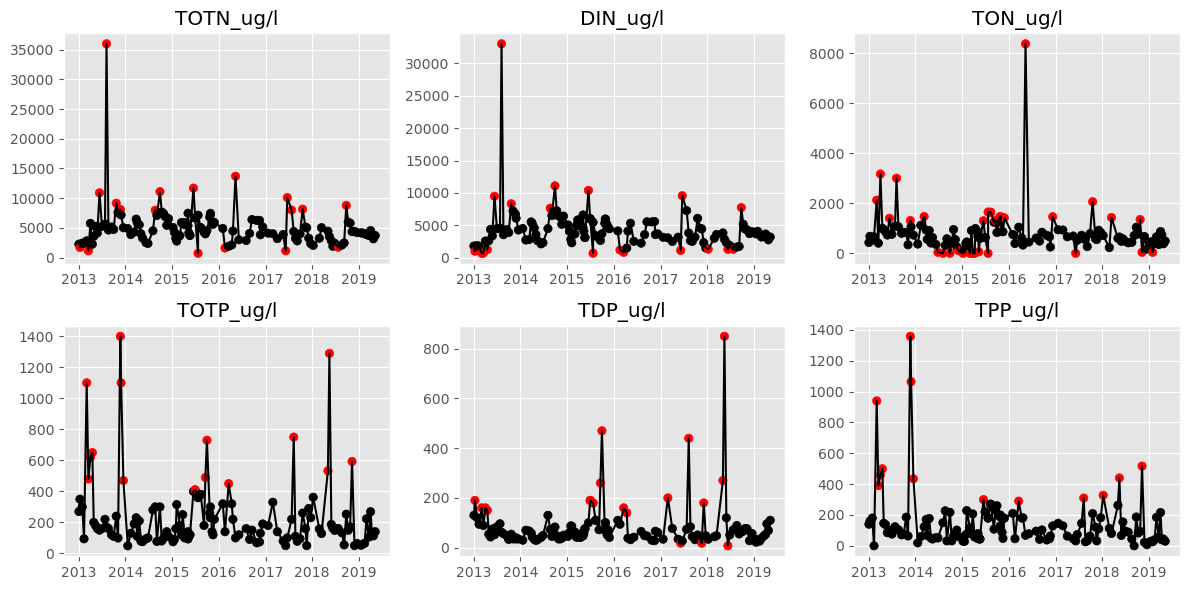

In [7]:
# Plot
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))
axes = axes.flatten()

for idx, par in enumerate(pars):
    par_df = df.query("parameter == @par").copy()
    par_df.sort_values("date", inplace=True)
    par_df["outlier_col"] = ["r" if i else "k" for i in par_df["outlier"]]
    axes[idx].plot(par_df["date"], par_df["value"], "k-")
    axes[idx].scatter(
        par_df["date"],
        par_df["value"],
        c=par_df["outlier_col"].tolist(),
    )
    axes[idx].set_title(par)
plt.tight_layout()

In [8]:
# Remove outliers
df = (
    df.query("outlier == False")
    .drop(columns="outlier")
    .set_index(["site_id", "date", "parameter"])
    .unstack("parameter")
)
df.columns = df.columns.get_level_values(1)
wc_df = df.reset_index()
wc_df.columns.name = ""
wc_df.head()

,site_id,date,DIN_ug/l,TDP_ug/l,TON_ug/l,TOTN_ug/l,TOTP_ug/l,TPP_ug/l
0,126-54258,2013-01-02,1820.0,130.0,430.0,2250.0,270.0,140.0
1,126-54258,2013-01-10,NaN,NaN,680.0,NaN,350.0,160.0
2,126-54258,2013-01-28,1900.0,120.0,530.0,2430.0,300.0,180.0
3,126-54258,2013-02-11,1730.0,94.0,660.0,2390.0,94.0,0.0
4,126-54258,2013-03-04,NaN,NaN,NaN,2820.0,NaN,NaN


## 2. Get discharge and estimate fluxes

In [9]:
nve_stn_df = nivapy.da.get_nve_hydapi_stations()
nve_id = stn_df["nve_station_id"].iloc[0]
nve_stn_df = nve_stn_df.query("station_id == @nve_id")
nve_stn_df

,station_id,station_name,latitude,longitude,utmEast_Z33,utmNorth_Z33,masl,riverName,councilNumber,councilName,...,culQ5,culQ10,culQ20,culQ50,culHm,culH5,culH10,culH20,culH50,seriesList
302,126.2.0,Engstad,63.68956,11.1557,309970,7068139,12,Hottranelva,5037,Levanger,...,18.8667,23.1899,27.7556,34.3418,1.9666,2.2751,2.5737,2.8731,3.2826,"[{'parameterName': 'Vannføring', 'parameter': ..."


In [10]:
# Derive catchment boundaries for chem and Q stations
stn_gdf = nivapy.spatial.derive_watershed_boundaries(
    stn_df,
    id_col="site_id",
    xcol="lon",
    ycol="lat",
    crs="epsg:4326",
    min_size_km2=5,
    dem_res_m=40,
    buffer_km=None,
    temp_fold=None,
    reproject=False,
)
stn_gdf["chem_area_km2"] = stn_gdf.to_crs({"proj": "cea"}).geometry.area / 1e6

nve_gdf = nivapy.spatial.derive_watershed_boundaries(
    nve_stn_df,
    id_col="station_id",
    xcol="longitude",
    ycol="latitude",
    crs="epsg:4326",
    min_size_km2=5,
    dem_res_m=40,
    buffer_km=None,
    temp_fold=None,
    reproject=False,
)
nve_gdf["q_area_km2"] = nve_gdf.to_crs({"proj": "cea"}).geometry.area / 1e6
nve_gdf["nve_station_id"] = nve_gdf["station_id"]

# Join areas back to 'stn_df' and compare to NVE values for the Q stations (from HydAPI)
stn_df = pd.merge(
    stn_df,
    stn_gdf[["site_id", "chem_area_km2"]],
    how="left",
    on="site_id",
)
stn_df = pd.merge(
    stn_df,
    nve_gdf[["nve_station_id", "q_area_km2"]],
    how="left",
    on="nve_station_id",
)

stn_df

Connection successful.


Looping over vassdragsområder:   0%|          | 0/1 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 126:   0%|          | 0/1 [00:00<?, ?it/s]

Connection successful.


Looping over vassdragsområder:   0%|          | 0/1 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 126:   0%|          | 0/1 [00:00<?, ?it/s]

,site_id,site_name,lat,lon,nve_station_id,regine,chem_area_km2,q_area_km2
0,126-54258,Hotranvassdraget (Leiraelva) ved Svendgårdsvegen,63.68945,11.15565,126.2.0,126.4Z,19.876389,19.876389


In [11]:
# Estimate annual fluxes
df_list = []
for idx, row in stn_df.iterrows():
    vm_id = row["site_id"]
    nve_id = row["nve_station_id"]
    area_fac = row["chem_area_km2"] / row["q_area_km2"]

    # Get chem data for station
    chem_stn_df = wc_df.query("site_id == @vm_id").copy()
    chem_stn_df.set_index("date", inplace=True)
    chem_stn_df = chem_stn_df[pars].resample("D").mean().dropna()

    # Get flow data for stations
    q_stn_df = nivapy.da.query_nve_hydapi(
        [nve_id], [1001], f"2013-01-01", f"2022-12-31", resolution=1440
    )
    q_stn_df = area_fac * q_stn_df.set_index("datetime")[["value"]].resample("D").mean()
    q_stn_df.index = q_stn_df.index.tz_localize(None)
    q_stn_df.rename(columns={"value": "flow_m3/s"}, inplace=True)

    # Calculate annual fluxes
    flux_df = nivapy.stats.estimate_fluxes(
        q_stn_df,
        chem_stn_df,
        base_freq="D",
        agg_freq="A",
        method="ospar_annual",
    )

    # Convert kg to tonnes
    flux_df = flux_df / 1000
    flux_df.columns = [col.replace("kg", "tonnes") for col in flux_df.columns]
    flux_df["site_id"] = vm_id
    df_list.append(flux_df)
flux_df = pd.concat(df_list, axis="rows")
flux_df = flux_df.reset_index()

flux_df

,year,TOTN_tonnes,DIN_tonnes,TON_tonnes,TOTP_tonnes,TDP_tonnes,TPP_tonnes,site_id
0,2013,56.922385,47.893378,9.029008,1.901758,0.607579,1.294178,126-54258
1,2014,185.055182,170.111225,14.943957,3.030112,1.164959,1.865152,126-54258
2,2015,103.335444,85.539589,17.178145,3.406522,1.247756,2.158767,126-54258
3,2016,51.683178,45.563492,6.119686,2.579235,0.770464,1.808771,126-54258
4,2017,48.602837,36.923476,11.679362,2.586363,0.647231,1.939132,126-54258
5,2018,55.406527,48.377142,7.029385,1.709279,0.776394,0.932885,126-54258
6,2019,52.567419,46.249366,6.318053,1.434543,0.577439,0.857104,126-54258
7,2020,NaN,NaN,NaN,NaN,NaN,NaN,126-54258
8,2021,NaN,NaN,NaN,NaN,NaN,NaN,126-54258
9,2022,NaN,NaN,NaN,NaN,NaN,NaN,126-54258


## 3. Model results

In [12]:
nve_data_year = 2023
st_yr, end_yr = 2013, 2022
out_csv_fold = r"/home/jovyan/shared/common/teotil3/annual_input_data"
eval_fold = r"/home/jovyan/shared/common/teotil3/evaluation"

In [13]:
def remove_prefix(text, prefix):
    if text.startswith(prefix):
        return text[len(prefix) :]
    return text


# Read saved data for speed
mod_csv = os.path.join(
    eval_fold, f"teo3_results_nve{nve_data_year}_{st_yr}-{end_yr}.csv"
)
mod_df = pd.read_csv(mod_csv)

# Tidy modelled data for comparison
cols = [col for col in mod_df.columns if col.startswith("accum_")]
mod_df = mod_df[["regine", "year"] + cols].copy()
cols = [remove_prefix(col, "accum_") for col in cols]
mod_df.columns = ["regine", "year"] + cols
for col in cols:
    if col.endswith("_kg"):
        mod_df[col[:-3] + "_tonnes"] = mod_df[col] / 1000
    del mod_df[col]

reg_id = stn_df["regine"].iloc[0]
mod_df = mod_df.query("regine in @reg_id")
mod_df.head()

,regine,year,agriculture-background_din_tonnes,agriculture-background_ss_tonnes,agriculture-background_tdp_tonnes,agriculture-background_toc_tonnes,agriculture-background_ton_tonnes,agriculture-background_totn_tonnes,agriculture-background_totp_tonnes,agriculture-background_tpp_tonnes,...,urban_totp_tonnes,urban_tpp_tonnes,wood_din_tonnes,wood_ss_tonnes,wood_tdp_tonnes,wood_toc_tonnes,wood_ton_tonnes,wood_totn_tonnes,wood_totp_tonnes,wood_tpp_tonnes
4879,126.4Z,2013,9.172648,72.140475,0.117054,153.862946,2.422840,11.595488,0.256996,0.139942,...,0.094060,0.023961,0.268308,7.081988,0.014987,114.762345,2.747570,3.015878,0.052751,0.037764
29081,126.4Z,2014,7.506189,42.559306,0.079631,104.671727,1.971780,9.477970,0.174832,0.095201,...,0.063995,0.016282,0.182477,7.081988,0.010245,78.071843,1.869149,2.051625,0.035955,0.025710
53283,126.4Z,2015,8.188305,82.426042,0.129016,169.586167,2.179360,10.367665,0.283258,0.154242,...,0.103604,0.026391,0.295728,7.081988,0.016505,126.489816,3.028436,3.324164,0.058108,0.041603
77485,126.4Z,2016,8.039597,65.306778,0.108852,143.081309,2.127774,10.167371,0.238987,0.130136,...,0.087426,0.022260,0.249481,7.081988,0.013944,106.720598,2.555128,2.804610,0.049083,0.035139
101687,126.4Z,2017,10.527316,108.862729,0.158066,207.771131,2.796643,13.323959,0.347038,0.188973,...,0.126987,0.032320,0.362347,7.081988,0.020205,154.970997,3.710270,4.072617,0.071188,0.050983


In [14]:
for col in mod_df.columns:
    if col not in ('regine', 'year'):
        mod_df[col] = mod_df[col] * 19.88 / 57.59

In [15]:
# Merge
comp_df = pd.merge(flux_df, mod_df, how="left", on="year")
comp_df.head()

,year,TOTN_tonnes,DIN_tonnes,TON_tonnes,TOTP_tonnes,TDP_tonnes,TPP_tonnes,site_id,regine,agriculture-background_din_tonnes,...,urban_totp_tonnes,urban_tpp_tonnes,wood_din_tonnes,wood_ss_tonnes,wood_tdp_tonnes,wood_toc_tonnes,wood_ton_tonnes,wood_totn_tonnes,wood_totp_tonnes,wood_tpp_tonnes
0,2013,56.922385,47.893378,9.029008,1.901758,0.607579,1.294178,126-54258,126.4Z,3.166387,...,0.032469,0.008271,0.092620,2.444694,0.005174,39.615826,0.948458,1.041078,0.018210,0.013036
1,2014,185.055182,170.111225,14.943957,3.030112,1.164959,1.865152,126-54258,126.4Z,2.591128,...,0.022091,0.005620,0.062991,2.444694,0.003536,26.950308,0.645228,0.708219,0.012412,0.008875
2,2015,103.335444,85.539589,17.178145,3.406522,1.247756,2.158767,126-54258,126.4Z,2.826593,...,0.035764,0.009110,0.102085,2.444694,0.005698,43.664135,1.045412,1.147497,0.020059,0.014361
3,2016,51.683178,45.563492,6.119686,2.579235,0.770464,1.808771,126-54258,126.4Z,2.775259,...,0.030179,0.007684,0.086121,2.444694,0.004813,36.839824,0.882027,0.968148,0.016943,0.012130
4,2017,48.602837,36.923476,11.679362,2.586363,0.647231,1.939132,126-54258,126.4Z,3.634017,...,0.043836,0.011157,0.125082,2.444694,0.006975,53.495805,1.280781,1.405863,0.024574,0.017599


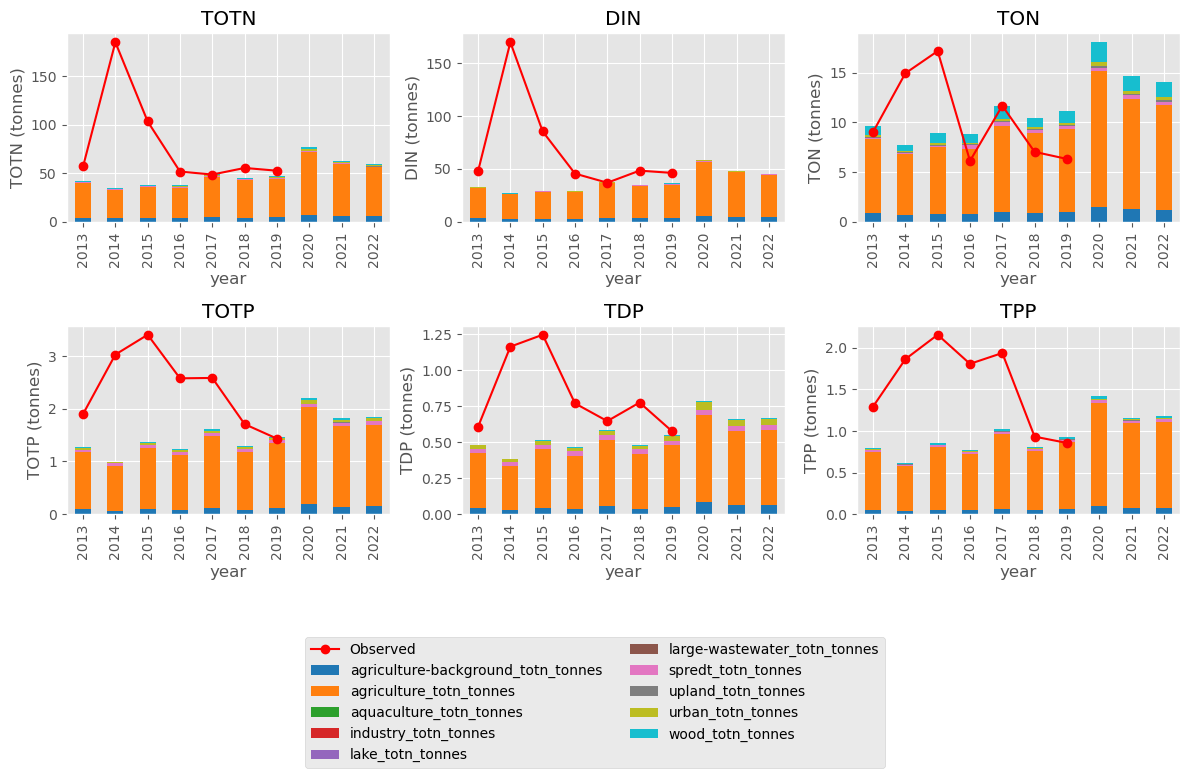

In [16]:
# Plot: single parameter per river
pars = [par.split("_")[0] for par in pars]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))
axes = axes.flatten()

for idx, par in enumerate(pars):
    par_cols = [
        col
        for col in comp_df.columns
        if par.lower() in (i.lower() for i in col.split("_"))
    ]

    comp_par_df = comp_df.set_index("year")[par_cols]

    comp_par_df.drop(columns=[f"{par}_tonnes"]).plot(
        kind="bar",
        stacked=True,
        ax=axes[idx],
        legend=False,
        cmap="tab10",
    )

    axes[idx].plot(
        comp_par_df.index - comp_par_df.index.min(),
        comp_par_df[f"{par}_tonnes"],
        marker="o",
        color="red",
        label="Observed",
    )
    axes[idx].set_title(par)
    axes[idx].set_ylabel(f"{par} (tonnes)")
plt.tight_layout()

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", bbox_to_anchor=(0.5, -0.3), ncol=2)